## Non-negative Matrix Factorization

This notebook generates data according to two clusters. The aim is that the estimated projection $\mathbf{\hat U}$ clearly separates the groups.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from edward.models import Poisson, Gamma, Bernoulli, RelaxedBernoulli, TransformedDistribution, Normal

plt.style.use('ggplot')

In [2]:
N = 500 # number of observations
M = 2 # data dimension
D = 2 # lower-dimensional space
K = 2 # number of clusters

labels = ['cell type 1', 'cell type 2']

In [3]:
# Generation of U: a matrix with block diagonal matrix with each block corresponding to a group
# Each entry in each block is drawn from a Gamma(alpha + eps, 1) and the rest are drawn from a Gamma(alpha, 1). 
# Thus, eps defines how distinct the two groups are.

alpha = 1.
eps = 5.

U_data = np.random.gamma(alpha, 1., size=(D, N))
c_data = np.zeros((N,))
K = 2
for k in range(K):
    c_data[int(k*N/K):int((k+1)*N/K)] = c_data[int(k*N/K):int((k+1)*N/K)] + k
    U_data[int(k*D/K):int((k+1)*D/K), int(k*N/K):int((k+1)*N/K)] = np.random.gamma(alpha + eps, 1., size=(int(D/K), int(N/K)))

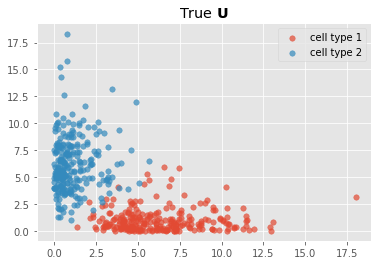

In [4]:
s = 30
alpha = 0.7

handlers = []
for k in range(K):
    h = plt.scatter(U_data[0, int(k*N/K):int((k+1)*N/K)], U_data[1, int(k*N/K):int((k+1)*N/K)], s=s, alpha=alpha)
    handlers.append(h)
    
plt.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')
plt.show()

In [5]:
# DATA
# the data contains 2 clusters, corresponding to different alphas and betas
alpha = 2.
beta = 2.

# NMF
V_data = np.random.gamma(alpha, 1./beta, size=(D, M))
R_data = np.matmul(U_data.T, V_data)
X_data = np.random.poisson(R_data)

In [6]:
X_data.shape

(500, 2)

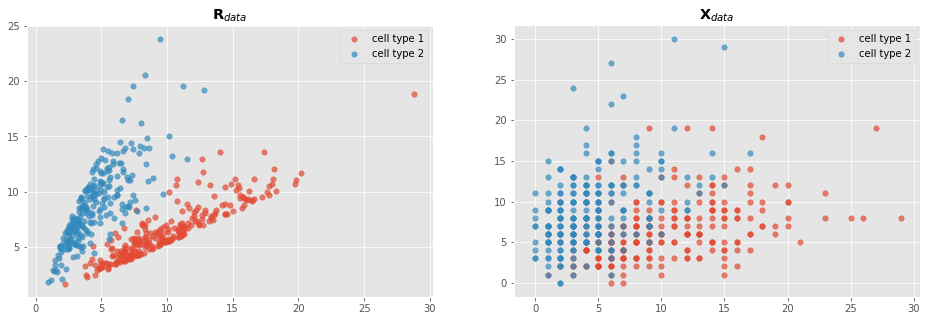

In [7]:
# Plot data
s = 30
alpha = 0.7

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(1, 2, 1)
handlers = []
for k in range(K):
    h = ax1.scatter(R_data[int(k*N/K):int((k+1)*N/K), 0], R_data[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('$\mathbf{R}_{data}$')

ax2 = plt.subplot(1, 2, 2)
handlers = []
for k in range(K):
    h = ax2.scatter(X_data[int(k*N/K):int((k+1)*N/K), 0], X_data[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('$\mathbf{X}_{data}$')

plt.show()

In [8]:
# MODEL

U = Gamma(2*tf.ones([N, D]), 1./2. * tf.ones([N, D]))
V = Gamma(2*tf.ones([D, M]), 1./2. * tf.ones([D, M]))
#V = V_data.astype('float32')

X = Poisson(rate=tf.matmul(U, V))

In [9]:
# INFERENCE
qU = TransformedDistribution(
    distribution=Normal(tf.Variable(tf.ones([N, D])), tf.nn.softplus(tf.Variable(0.01 * tf.ones([N, D])))),
    bijector=tf.contrib.distributions.bijectors.Exp())

qV = TransformedDistribution(
    distribution=Normal(tf.Variable(tf.ones([D, M])), tf.nn.softplus(tf.Variable(0.01 * tf.ones([D, M])))),
    bijector=tf.contrib.distributions.bijectors.Exp())

inference = ed.KLqp({U: qU, V: qV}, data={X: X_data})
inference.initialize()

tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

inference.finalize()

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:51: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 2959.456


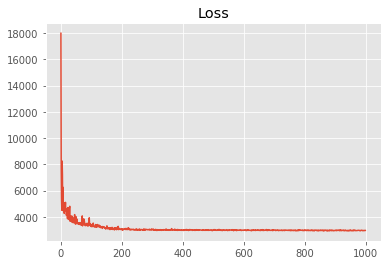

In [10]:
plt.plot(loss)
plt.title('Loss')
plt.show()

In [11]:
est_V = np.exp(qV.distribution.loc.eval())
est_U = np.exp(qU.distribution.loc.eval())

In [12]:
V_data

array([[1.51890824, 0.82141553],
       [0.4505572 , 1.2650229 ]])

In [13]:
est_V

array([[1.6880087 , 0.36033657],
       [0.12958156, 1.5917549 ]], dtype=float32)

## Clustering

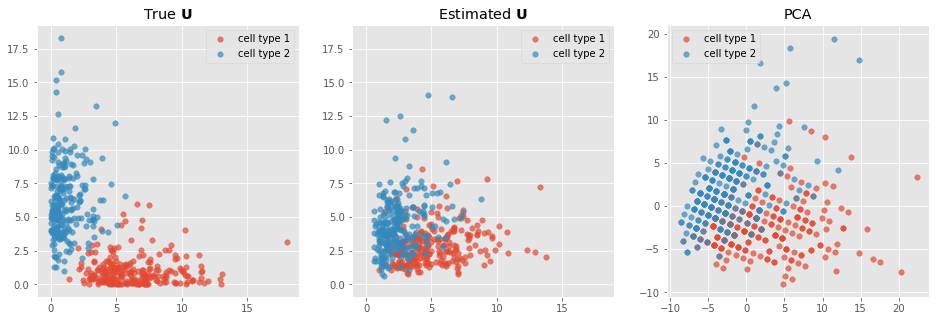

In [19]:
# Plot mean qU (estimated lower-dimensional data projection)
s = 30
alpha = 0.7

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(1, 3, 1)
handlers = []
for k in range(K):
    h = ax1.scatter(U_data[0, int(k*N/K):int((k+1)*N/K)], U_data[1, int(k*N/K):int((k+1)*N/K)], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')

ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
handlers = []
for k in range(K):
    h = ax2.scatter(est_U[int(k*N/K):int((k+1)*N/K), 0], est_U[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('Estimated $\mathbf{U}$')

pca_U = PCA(n_components=2).fit_transform(X_data)
ax3 = plt.subplot(1, 3, 3)
handlers = []
for k in range(K):
    h = ax3.scatter(pca_U[int(k*N/K):int((k+1)*N/K), 0], pca_U[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()

In [15]:
nmf_silh = silhouette_score(est_U, c_data)
pca_silh = silhouette_score(pca_U, c_data)

scores = {'NMF': nmf_silh, 'PCA': pca_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')

Silhouette scores (higher is better):
- PCA: 0.205
- NMF: 0.219


In [16]:
est_R = np.matmul(est_U, est_V)

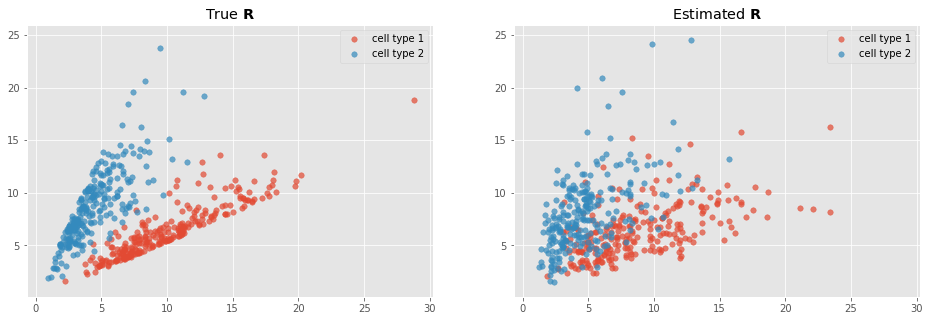

In [20]:
# Plot mean qU*qV (estimated mean rates)
s = 30
alpha = 0.7

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(1, 2, 1)
handlers = []
for k in range(K):
    h = ax1.scatter(R_data[int(k*N/K):int((k+1)*N/K), 0], R_data[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{R}$')

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
handlers = []
for k in range(K):
    h = ax2.scatter(est_R[int(k*N/K):int((k+1)*N/K), 0], est_R[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('Estimated $\mathbf{R}$')

plt.show()